In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("../../../../data/ds-jobs-ner.csv")
for col in ["sector", "size", "type_of_ownership", "state"]:
    df[col] = df[col].fillna("Unknown")

print(f"✅ {df.shape[0]} offres | target : salary_avg_k")

✅ 672 offres | target : salary_avg_k


### Corrélation toutes features vs target

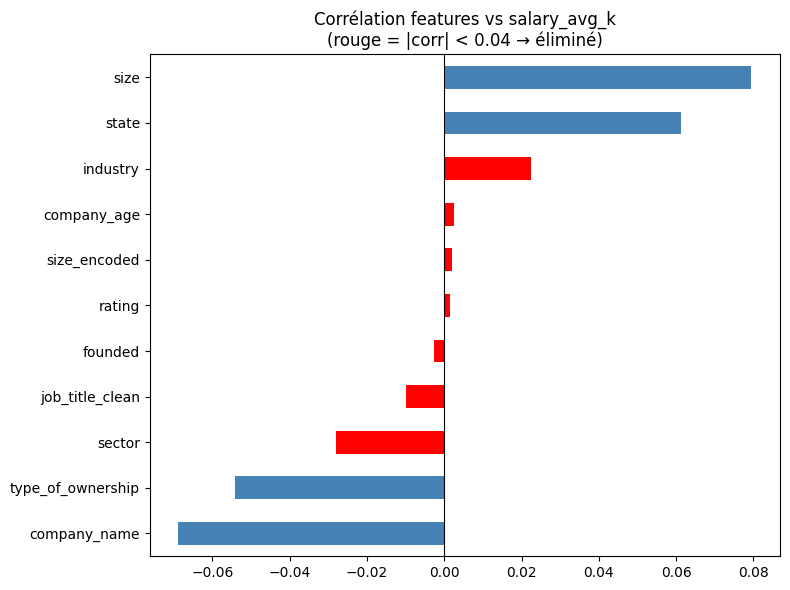

✅ Retenues : ['company_name', 'type_of_ownership', 'state', 'size']
❌ Éliminées: ['sector', 'job_title_clean', 'founded', 'rating', 'size_encoded', 'company_age', 'industry']


In [14]:
# Numériques
num_corr = df[["rating","founded","company_age","size_encoded","salary_avg_k"]]\
           .corr()["salary_avg_k"].drop("salary_avg_k")

# Catégoriels
cat_cols = ["sector","size","type_of_ownership","state","industry","job_title_clean","company_name"]
cat_corr = pd.Series({
    col: LabelEncoder().fit_transform(df[col].astype(str))
         .tolist() and pd.Series(LabelEncoder().fit_transform(df[col].astype(str)))
         .corr(df["salary_avg_k"])
    for col in cat_cols
})

all_corr = pd.concat([num_corr, cat_corr]).sort_values()

# Plot
colors = ["red" if abs(v) < 0.04 else "steelblue" for v in all_corr]
all_corr.plot(kind="barh", color=colors, figsize=(8,6))
plt.axvline(0, color="black", lw=0.8)
plt.title("Corrélation features vs salary_avg_k\n(rouge = |corr| < 0.04 → éliminé)")
plt.tight_layout()
plt.show()

print("✅ Retenues :", all_corr[all_corr.abs() >= 0.04].index.tolist())
print("❌ Éliminées:", all_corr[all_corr.abs() <  0.04].index.tolist())

###  Nulls : pourquoi revenue et competitors éliminés

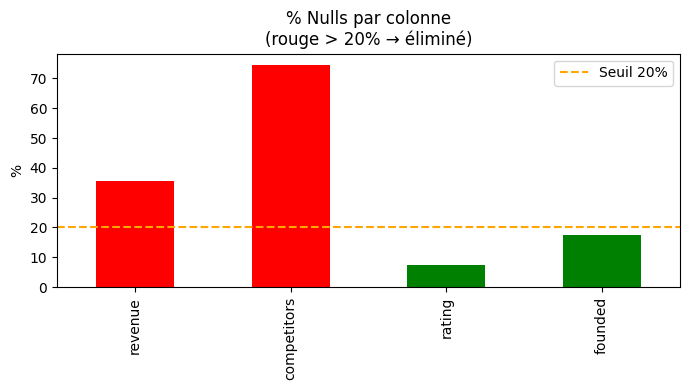

revenue        35.7
competitors    74.6
rating          7.4
founded        17.6
dtype: float64


In [11]:
null_pct = df[["revenue","competitors","rating","founded"]].isnull().mean() * 100

null_pct.plot(kind="bar", color=["red","red","green","green"], figsize=(7,4))
plt.axhline(20, color="orange", linestyle="--", label="Seuil 20%")
plt.title("% Nulls par colonne\n(rouge > 20% → éliminé)")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.show()

print(null_pct.round(1))

### Impact des mots-clés sur le salaire

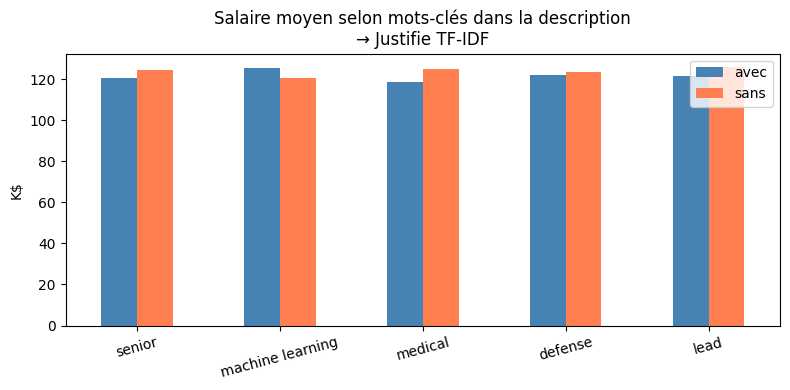

                   avec   sans  diff
senior            120.8  124.4  -3.6
machine learning  125.6  120.5   5.1
medical           118.6  125.0  -6.4
defense           122.2  123.8  -1.6
lead              121.5  126.2  -4.7


In [15]:
keywords = ["senior", "machine learning", "medical", "defense", "lead"]

results = pd.DataFrame({
    kw: {
        "avec": df[df["job_description_clean"].str.lower().str.contains(kw)]["salary_avg_k"].mean(),
        "sans": df[~df["job_description_clean"].str.lower().str.contains(kw)]["salary_avg_k"].mean(),
    }
    for kw in keywords
}).T.round(1)

results["diff"] = (results["avec"] - results["sans"]).round(1)

results[["avec","sans"]].plot(kind="bar", figsize=(8,4), color=["steelblue","coral"])
plt.title("Salaire moyen selon mots-clés dans la description\n→ Justifie TF-IDF")
plt.ylabel("K$")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print(results)

In [13]:
summary = pd.DataFrame([
    ("job_description_clean", "✅", "TF-IDF — mots influencent le salaire"),
    ("job_title_clean",       "✅", "TF-IDF — séniorité capturée"),
    ("sector",                "✅", "Corrélation -0.095 (la plus forte)"),
    ("size",                  "✅", "Corrélation +0.052"),
    ("type_of_ownership",     "✅", "Corrélation -0.054"),
    ("state",                 "✅", "Corrélation +0.061"),
    ("company_name",          "❌", "432 valeurs uniques → overfitting"),
    ("industry",              "❌", "Redondant avec sector"),
    ("revenue",               "❌", "36% nulls"),
    ("competitors",           "❌", "75% nulls"),
    ("rating",                "❌", "Corrélation 0.001 → inutile"),
    ("founded",               "❌", "Corrélation -0.003 → inutile"),
], columns=["Feature", "Utilisée", "Raison"])

print(summary.to_string(index=False))

              Feature Utilisée                               Raison
job_description_clean        ✅ TF-IDF — mots influencent le salaire
      job_title_clean        ✅          TF-IDF — séniorité capturée
               sector        ✅   Corrélation -0.095 (la plus forte)
                 size        ✅                   Corrélation +0.052
    type_of_ownership        ✅                   Corrélation -0.054
                state        ✅                   Corrélation +0.061
         company_name        ❌    432 valeurs uniques → overfitting
             industry        ❌                Redondant avec sector
              revenue        ❌                            36% nulls
          competitors        ❌                            75% nulls
               rating        ❌          Corrélation 0.001 → inutile
              founded        ❌         Corrélation -0.003 → inutile
